<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['kanye-west.txt',
 'Lil_Wayne.txt',
 'alicia-keys.txt',
 'adele.txt',
 'nicki-minaj.txt',
 'nursery_rhymes.txt',
 'joni-mitchell.txt',
 'dickinson.txt',
 'radiohead.txt',
 'lin-manuel-miranda.txt',
 'dj-khaled.txt',
 'britney-spears.txt',
 'al-green.txt',
 'jimi-hendrix.txt',
 'bruno-mars.txt',
 'dr-seuss.txt',
 'kanye.txt',
 'michael-jackson.txt',
 'nirvana.txt',
 'missy-elliott.txt',
 'notorious-big.txt',
 'janisjoplin.txt',
 'amy-winehouse.txt',
 'bieber.txt',
 'nickelback.txt',
 'notorious_big.txt',
 'rihanna.txt',
 'johnny-cash.txt',
 'Kanye_West.txt',
 'lady-gaga.txt',
 'bob-dylan.txt',
 'drake.txt',
 'patti-smith.txt',
 'cake.txt',
 'bjork.txt',
 'lorde.txt',
 'bob-marley.txt',
 'paul-simon.txt',
 'bruce-springsteen.txt',
 'disney.txt',
 'leonard-cohen.txt',
 'ludacris.txt',
 'r-kelly.txt',
 'blink-182.txt',
 'lil-wayne.txt',
 'eminem.txt',
 'dolly-parton.txt',
 'prince.txt',
 'beatles.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# Inicializa la variable df como una lista vacía
df = list()

# Lista de nombres de archivos .txt que deseas concatenar
archivos = ['songs_dataset/bruce-springsteen.txt',
            'songs_dataset/rihanna.txt',
            'songs_dataset/eminem.txt',
            #'songs_dataset/michael-jackson.txt'
            ]

# Itera a través de los archivos y concaténalos en df
for archivo in archivos:
  # Armar el dataset utilizando salto de línea para separar las oraciones/docs
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
  # Agrega df_aux a df
  df.append(df_aux)

df = pd.concat(df, ignore_index=True)
df.head()

<ipython-input-4-9d7463a4fd9a>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
<ipython-input-4-9d7463a4fd9a>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)
<ipython-input-4-9d7463a4fd9a>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_aux = pd.read_csv(archivo, sep='/n', header=None)


,0
0,[Verse 1]
1,They come from everywhere
2,A longing to be free
3,They come to join us here
4,From sea to shining sea And they all have a dream


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 13120


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 6

In [7]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'[Verse 1]'

In [8]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['verse', '1']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [9]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['verse', '1'], ['they', 'come', 'from', 'everywhere']]

In [11]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [13]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [14]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[]

In [15]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

0


In [16]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

0


In [17]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{}


In [18]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [19]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                             [Verse 1]
1                             They come from everywhere
2                                  A longing to be free
3                             They come to join us here
4     From sea to shining sea And they all have a dream
5                                 As people always will
6                                   To be safe and warm
7     In that shining city on the hill Some wanna sl...
8                           Instead of opening the gate
9                      Aw, let's turn this thing around
10                     Before it gets too late [Chorus]
11                                It's up to me and you
12                                Love can conquer hate
13                               I know this to be true
14                 That's what makes us great [Verse 2]
15                                  Don't tell me a lie
Name: 0, dtype: object

In [20]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'[Verse 1] They come from everywhere A longing to be free They come to join us here From sea to shining sea And they all have a dream As people always will To be safe and warm In that shining city on the hill Some wanna slam the door Instead of opening the gate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great [Verse 2] Don\'t tell me a lie And sell it as a fact I\'ve been down that road before And I ain\'t goin\' back And don\'t you brag to me That you never read a book I never put my faith In a con man and his crooks I won\'t follow down that path And tempt the hands of fate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great In the quiet of the night I lie here wide awake And I ask myself Is there a difference I can make? [Chorus] It\'s up to me and you Love can 

In [21]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['verse',
 '1',
 'they',
 'come',
 'from',
 'everywhere',
 'a',
 'longing',
 'to',
 'be',
 'free',
 'they',
 'come',
 'to',
 'join',
 'us',
 'here',
 'from',
 'sea',
 'to']

In [22]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 116583


In [23]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [24]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['verse', '1', 'they', 'come', 'from', 'everywhere'],
 ['1', 'they', 'come', 'from', 'everywhere', 'a'],
 ['they', 'come', 'from', 'everywhere', 'a', 'longing'],
 ['come', 'from', 'everywhere', 'a', 'longing', 'to'],
 ['from', 'everywhere', 'a', 'longing', 'to', 'be'],
 ['everywhere', 'a', 'longing', 'to', 'be', 'free'],
 ['a', 'longing', 'to', 'be', 'free', 'they'],
 ['longing', 'to', 'be', 'free', 'they', 'come'],
 ['to', 'be', 'free', 'they', 'come', 'to'],
 ['be', 'free', 'they', 'come', 'to', 'join'],
 ['free', 'they', 'come', 'to', 'join', 'us'],
 ['they', 'come', 'to', 'join', 'us', 'here'],
 ['come', 'to', 'join', 'us', 'here', 'from'],
 ['to', 'join', 'us', 'here', 'from', 'sea'],
 ['join', 'us', 'here', 'from', 'sea', 'to'],
 ['us', 'here', 'from', 'sea', 'to', 'shining'],
 ['here', 'from', 'sea', 'to', 'shining', 'sea'],
 ['from', 'sea', 'to', 'shining', 'sea', 'and'],
 ['sea', 'to', 'shining', 'sea', 'and', 'they'],
 ['to', 'shining', 'sea', 'and', 'they', 'all']]

In [25]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[525, 750, 45, 51, 61, 961],
 [750, 45, 51, 61, 961, 5],
 [45, 51, 61, 961, 5, 1939],
 [51, 61, 961, 5, 1939, 4],
 [61, 961, 5, 1939, 4, 27],
 [961, 5, 1939, 4, 27, 423],
 [5, 1939, 4, 27, 423, 45],
 [1939, 4, 27, 423, 45, 51],
 [4, 27, 423, 45, 51, 4],
 [27, 423, 45, 51, 4, 2323],
 [423, 45, 51, 4, 2323, 142],
 [45, 51, 4, 2323, 142, 83],
 [51, 4, 2323, 142, 83, 61],
 [4, 2323, 142, 83, 61, 1008],
 [2323, 142, 83, 61, 1008, 4],
 [142, 83, 61, 1008, 4, 598],
 [83, 61, 1008, 4, 598, 1008],
 [61, 1008, 4, 598, 1008, 6],
 [1008, 4, 598, 1008, 6, 45],
 [4, 598, 1008, 6, 45, 24]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 116577


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(116577, 5)
(116577,)


In [31]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'you',
 4: 'to',
 5: 'a',
 6: 'and',
 7: 'me',
 8: 'my',
 9: 'it',
 10: 'in',
 11: "i'm",
 12: 'that',
 13: 'like',
 14: 'on',
 15: 'your',
 16: 'of',
 17: 'but',
 18: 'this',
 19: "don't",
 20: 'just',
 21: 'so',
 22: 'is',
 23: 'up',
 24: 'all',
 25: 'for',
 26: 'love',
 27: 'be',
 28: 'with',
 29: 'no',
 30: 'know',
 31: 'get',
 32: 'now',
 33: "it's",
 34: 'what',
 35: 'got',
 36: 'out',
 37: 'yeah',
 38: 'oh',
 39: 'we',
 40: 'when',
 41: 'go',
 42: 'was',
 43: 'can',
 44: 'baby',
 45: 'they',
 46: 'if',
 47: "ain't",
 48: 'one',
 49: 'at',
 50: 'do',
 51: 'come',
 52: 'back',
 53: 'down',
 54: 'not',
 55: "you're",
 56: 'take',
 57: "'cause",
 58: 'way',
 59: 'see',
 60: 'let',
 61: 'from',
 62: 'never',
 63: 'he',
 64: 'make',
 65: 'want',
 66: 'night',
 67: "can't",
 68: 'say',
 69: 'wanna',
 70: 'fuck',
 71: "that's",
 72: 'feel',
 73: 'as',
 74: 'have',
 75: 'how',
 76: 'shit',
 77: 'her',
 78: 'right',
 79: 'girl',
 80: 'think',
 81: 'too',
 82: 'are'

In [32]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

7519

In [33]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [34]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [35]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(116577, 7519)

### 4 - Entrenar el modelo

In [38]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

5

In [36]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

7519

In [37]:
output_dim = np.round(vocab_size**(1/4),0).astype(np.int64)
output_dim

9

In [39]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=output_dim, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 9)              67680     
                                                                 
 lstm (LSTM)                 (None, 5, 64)             18944     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7519)              248127    
                                                                 
Total params: 369855 (1.41 MB)
Trainable params: 369855 

In [40]:
hist = model.fit(x_data, y_data, epochs=80, validation_split=0.2)

Epoch 1/80
2915/2915 [==============================] - 60s 16ms/step - loss: 6.4834 - accuracy: 0.0363 - val_loss: 6.7760 - val_accuracy: 0.0365
Epoch 2/80
2915/2915 [==============================] - 38s 13ms/step - loss: 6.0526 - accuracy: 0.0458 - val_loss: 6.7382 - val_accuracy: 0.0538
Epoch 3/80
2915/2915 [==============================] - 38s 13ms/step - loss: 5.7534 - accuracy: 0.0652 - val_loss: 6.8681 - val_accuracy: 0.0591
Epoch 4/80
2915/2915 [==============================] - 43s 15ms/step - loss: 5.5272 - accuracy: 0.0813 - val_loss: 6.9969 - val_accuracy: 0.0657
Epoch 5/80
2915/2915 [==============================] - 39s 13ms/step - loss: 5.3250 - accuracy: 0.0941 - val_loss: 7.1276 - val_accuracy: 0.0650
Epoch 6/80
2915/2915 [==============================] - 38s 13ms/step - loss: 5.1412 - accuracy: 0.1078 - val_loss: 7.4328 - val_accuracy: 0.0689
Epoch 7/80
2915/2915 [==============================] - 38s 13ms/step - loss: 4.9809 - accuracy: 0.1183 - val_loss: 7.4998 -

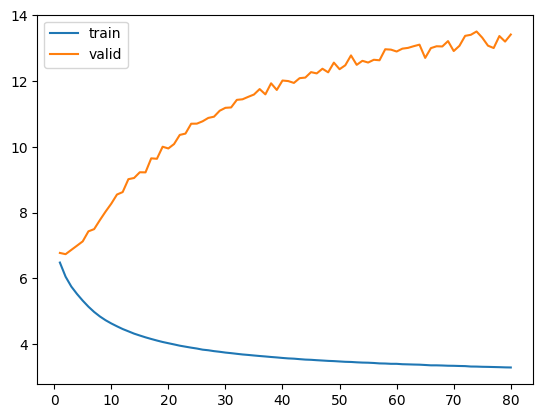

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [43]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [44]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.6 MB/s eta 0

In [45]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-45-2a8fe09160a6>:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4f530a0c4d6f6e0bb5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ReadTimeout: ignored

### 6 - Generación de secuencias nuevas

In [46]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [54]:
input_text='are you looking for some body'

generate_seq(model, tok, input_text, max_length=5, n_words=5)

1/1 [==============================] - 0s 56ms/step


"are you looking for some body i'm behind life i'm down"

### 7 - Beam search y muestreo aleatorio

In [55]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [56]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [60]:
# predicción con beam search
salidas = beam_search(model,num_beams=5,num_words=5,input="when i find myself in times")

1/1 [==============================] - 0s 83ms/step


ValueError: ignored

In [ ]:
# veamos las salidas
decode(salidas[0])

### 8 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.